# Методы понижения размерности

## Задача 3

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels as sm
import scipy.stats as sps
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD, IncrementalPCA, KernelPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from sklearn.manifold import TSNE, Isomap
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10,5 

%matplotlib inline

In [2]:
df = pd.read_csv('hw11t3_train.csv')
df.head()

Unnamed: 0  Washington     Carter    Clinton   Bush jr.  Roosevelt  \
0           0    3.734073  -9.457681  27.549700 -11.985751   1.901486   
1           1    2.551721 -24.627005 -15.520941  12.029495   3.703952   
2           2    2.918376   5.445903  33.389551   2.186544   1.409118   
3           3    2.560226  13.506337  25.484365  11.080659   1.083449   
4           4    2.424035 -19.448434 -30.360407   7.138340   4.142661   

        Tucker     Trump  Eisenhower     Reagan       Ford      Nixon  \
0  -669.538235  6.072319   -1.046536  -1.850577  -8.462503  28.644939   
1   365.589767  6.115587   -0.834076  12.575440   4.661140  16.216623   
2 -1085.204284  2.380016    3.450318   0.168421 -29.750741  45.294247   
3  -467.031753  5.876512   -1.977780   3.577079  -6.203411  29.395979   
4  -543.512743  3.921131   -3.514755   6.543723 -37.061819  42.713911   

      Johnson     Kennedy  
0  165.300587  -59.154245  
1  -98.009037 -146.352608  
2   84.329562   -9.409634  
3  147.616360  -98.203858  
4 -133.607567 -121.587831

In [3]:
X = df.drop('Washington', axis=1).values
y = df['Washington'].values

В качестве теста возьмём произвольные 100 элементов.

In [4]:
test_indexes = np.random.choice(np.arange(len(X)), 50)
train_indexes = np.setdiff1d(np.arange(len(X)), test_indexes)
X_train = X[train_indexes]
y_train = y[train_indexes]
X_test = X[test_indexes]
y_test = y[test_indexes]

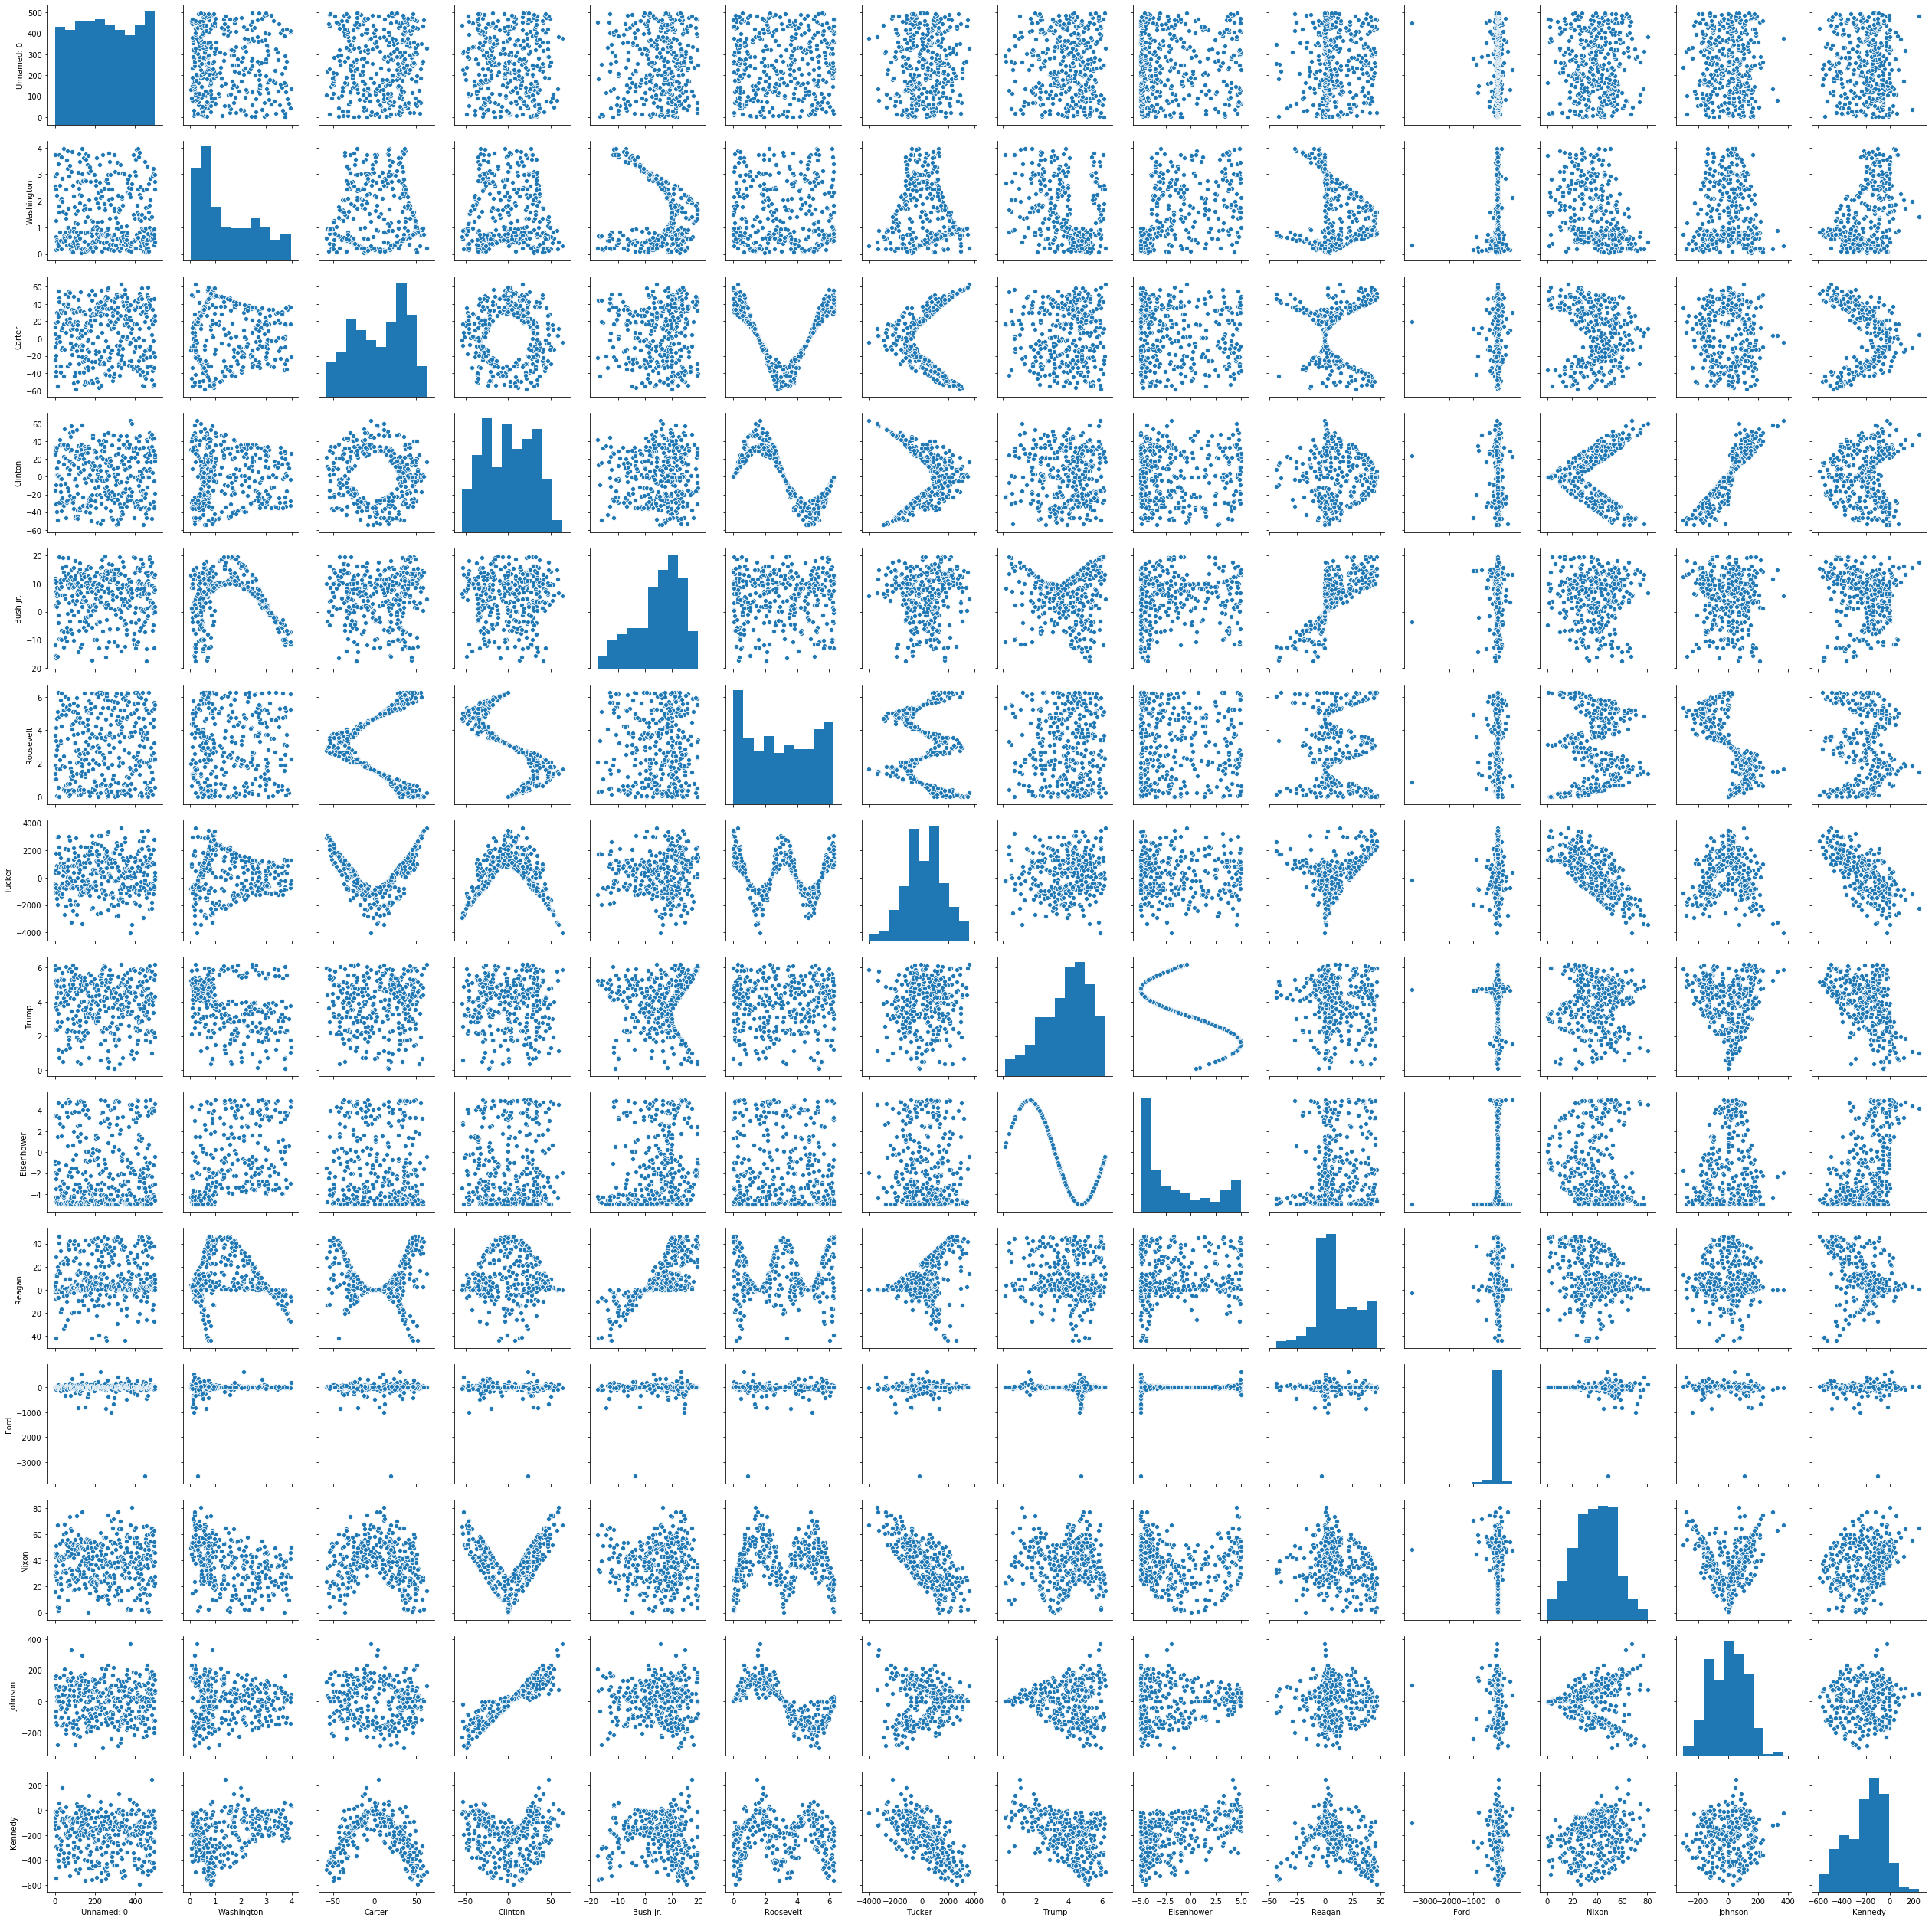

In [5]:
sns.pairplot(df.loc[train_indexes, :])
plt.show()

Видим, что данные довольно сильно зависимы и многие зависимости нелинейны $\Rightarrow$ будем использовать KernelPCA. Сначала стандартизируем данные, а также посмотрим на корреляцию признаков.

In [6]:
corr = pd.DataFrame(X_train).corr(method='spearman')
corr

0         1         2         3         4         5         6   \
0   1.000000  0.030797 -0.018196  0.026495  0.052745  0.044242 -0.026942   
1   0.030797  1.000000 -0.007935  0.040446 -0.095609  0.260723  0.063343   
2  -0.018196 -0.007935  1.000000  0.008055 -0.666952  0.009425  0.005576   
3   0.026495  0.040446  0.008055  1.000000  0.022154  0.066068  0.062619   
4   0.052745 -0.095609 -0.666952  0.022154  1.000000 -0.098142 -0.033259   
5   0.044242  0.260723  0.009425  0.066068 -0.098142  1.000000  0.100839   
6  -0.026942  0.063343  0.005576  0.062619 -0.033259  0.100839  1.000000   
7   0.023152 -0.094289  0.023707  0.091195 -0.002461 -0.086414 -0.701246   
8   0.078607  0.124406  0.015997  0.788173 -0.008034  0.437288 -0.040161   
9  -0.011572  0.051585 -0.047833  0.053073 -0.026046  0.046141 -0.002312   
10  0.001195 -0.178768  0.071702  0.051028  0.034924 -0.702523  0.027042   
11 -0.005944 -0.005093  0.942737 -0.024536 -0.672434 -0.003906 -0.014322   
12 -0.058627 -0.235860  0.002625 -0.174508  0.052067 -0.699385 -0.456540   

          7         8         9         10        11        12  
0   0.023152  0.078607 -0.011572  0.001195 -0.005944 -0.058627  
1  -0.094289  0.124406  0.051585 -0.178768 -0.005093 -0.235860  
2   0.023707  0.015997 -0.047833  0.071702  0.942737  0.002625  
3   0.091195  0.788173  0.053073  0.051028 -0.024536 -0.174508  
4  -0.002461 -0.008034 -0.026046  0.034924 -0.672434  0.052067  
5  -0.086414  0.437288  0.046141 -0.702523 -0.003906 -0.699385  
6  -0.701246 -0.040161 -0.002312  0.027042 -0.014322 -0.456540  
7   1.000000  0.106471  0.063529 -0.207546  0.063090  0.459252  
8   0.106471  1.000000  0.059243 -0.244283 -0.001868 -0.402877  
9   0.063529  0.059243  1.000000 -0.002908 -0.067591 -0.016164  
10 -0.207546 -0.244283 -0.002908  1.000000  0.055791  0.289296  
11  0.063090 -0.001868 -0.067591  0.055791  1.000000  0.020996  
12  0.459252 -0.402877 -0.016164  0.289296  0.020996  1.000000

Видим, что признаки не сильно скоррелированы.

In [7]:
X_test -= X_train.mean(axis=0)
X_test /= X_train.std(axis=0)
X_train -= X_train.mean(axis=0)
X_train /= X_train.std(axis=0)

Воспользуемся KernalPCA для разных ядер.

In [56]:
train_data = np.array(X_train)
train_targs = np.array(y_train)
skf = KFold(n_splits=10, shuffle=True, random_state=0)
lr = Ridge()
n_arr = np.arange(1, 92)
def printKernelPCA(kernel):
    for n in n_arr:
        rmses = []
        pca = KernelPCA(n_components=n, kernel=kernel)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.fit_transform(X_test)
        for fold in skf.split(X_train_pca):
            pca.fit(train_data[fold[0]])
            train = pca.transform(train_data[fold[0]])
            test = pca.transform(train_data[fold[1]])
            lr.fit(train, train_targs[fold[0]])
            predictions = lr.predict(test)
            rmses.append(np.sqrt(mean_squared_error(predictions, train_targs[fold[1]])))
        print('n = {}, RMSE = {}'.format(n, np.mean(rmses)))
        rmses_ns.append(np.mean(rmses))  

In [54]:
printKernelPCA('poly')

n = 1, RMSE = 1.1269430840859715
n = 2, RMSE = 1.1148148675807044
n = 3, RMSE = 1.1196000004313296
n = 4, RMSE = 1.0757256672143398
n = 5, RMSE = 0.9811656152195148
n = 6, RMSE = 0.9791679707440502
n = 7, RMSE = 0.9861007386875139
n = 8, RMSE = 0.9855383784195892
n = 9, RMSE = 1.1348075825952297
n = 10, RMSE = 0.9370616049077152
n = 11, RMSE = 0.8941214655560372
n = 12, RMSE = 0.8333586536923157
n = 13, RMSE = 0.8416199290162162
n = 14, RMSE = 0.8432036953214073
n = 15, RMSE = 0.8634667908663844
n = 16, RMSE = 0.8230744040947583
n = 17, RMSE = 0.805199254105761
n = 18, RMSE = 0.7899288196666674
n = 19, RMSE = 0.7850606529647507
n = 20, RMSE = 0.7815566232004787
n = 21, RMSE = 0.7794446571621272
n = 22, RMSE = 0.7644988119841755
n = 23, RMSE = 0.7764383277300191
n = 24, RMSE = 0.7642697973309384
n = 25, RMSE = 0.7804296587681161
n = 26, RMSE = 0.7770403696659581
n = 27, RMSE = 0.7826607814763247
n = 28, RMSE = 0.7790036581165285
n = 29, RMSE = 0.7759677724708535
n = 30, RMSE = 0.7599052

In [55]:
printKernelPCA('rbf')

n = 1, RMSE = 1.1339355300992076
n = 2, RMSE = 1.0808521445181656
n = 3, RMSE = 1.0201785213054535
n = 4, RMSE = 0.9018884697140763
n = 5, RMSE = 0.9004625917122009
n = 6, RMSE = 0.8920557712983321
n = 7, RMSE = 0.8646644518856578
n = 8, RMSE = 0.8484605709759665
n = 9, RMSE = 0.8436566667248881
n = 10, RMSE = 0.8183361113794112
n = 11, RMSE = 0.8184004251597654
n = 12, RMSE = 0.8195094936090891
n = 13, RMSE = 0.8201614611835482
n = 14, RMSE = 0.7618098603382137
n = 15, RMSE = 0.7287517736491933
n = 16, RMSE = 0.7242927010138704
n = 17, RMSE = 0.7153233606056466
n = 18, RMSE = 0.712943195279735
n = 19, RMSE = 0.7104661223367172
n = 20, RMSE = 0.7109714805736348
n = 21, RMSE = 0.7086343032712982
n = 22, RMSE = 0.7068930269506037
n = 23, RMSE = 0.694792279379602
n = 24, RMSE = 0.6929441784187367
n = 25, RMSE = 0.6919184374475029
n = 26, RMSE = 0.6898697818655836
n = 27, RMSE = 0.6896940293286351
n = 28, RMSE = 0.6913665767431019
n = 29, RMSE = 0.6886017047397518
n = 30, RMSE = 0.68947864

Ядро rbf даёт чуть лучшие результаты.

Теперь воспользуемся TSNE.

In [67]:
skf = KFold(n_splits=10, random_state=42, shuffle=True)
for n in [2, 3]:
    pca = TSNE(n_components=n, perplexity=60)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.fit_transform(X_test)
    lr = Ridge()
    rmses = []
    for fold in skf.split(X_train_pca):
        cur_X_train, cur_X_test = X_train_pca[fold[0]], X_train_pca[fold[1]]
        cur_y_train, cur_y_test = y_train[fold[0]], y_train[fold[1]]
        lr.fit(cur_X_train, cur_y_train)
        y_preds = lr.predict(cur_X_test)
        rmses.append(np.sqrt(mean_squared_error(cur_y_test, y_preds)))
    print('n = {}, RMSE = {}'.format(n, np.mean(rmses)))

n = 2, RMSE = 1.0978089239527813
n = 3, RMSE = 1.1034606740508075


Для разного параметра perplexity, а также от запуска к запуску получаем разный результат. В некоторых случаях удаётся улучшить RMSE относительно KernelPCA с ядром rbf (на размерности 2), иногда нет. Но в целом, они примерно на одном уровне.

## Задача 4

In [68]:
from sklearn.datasets import fetch_olivetti_faces

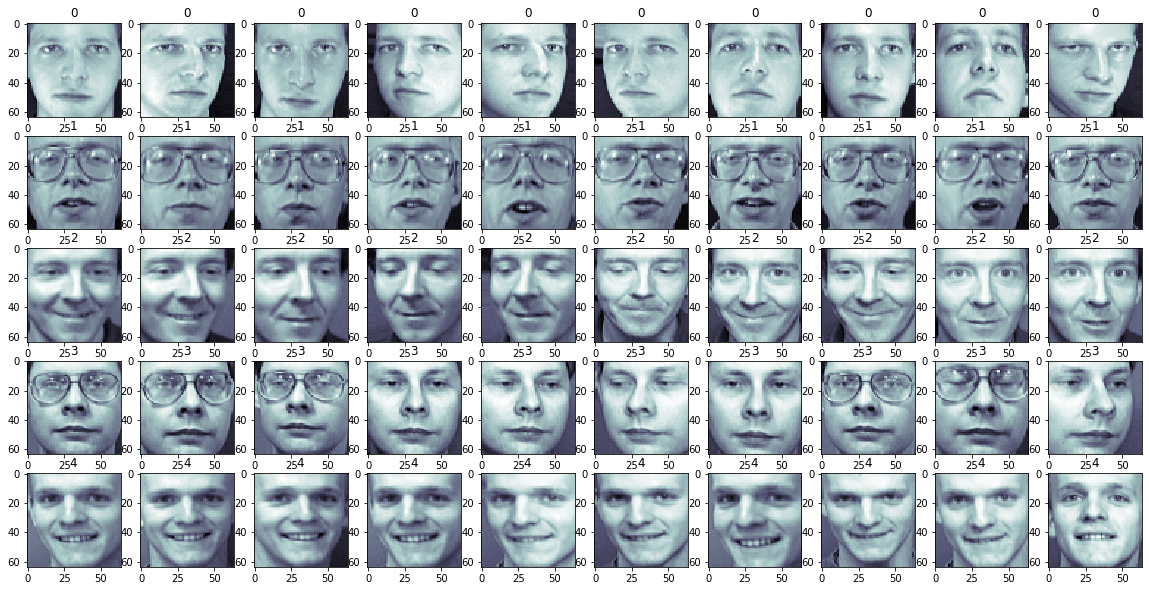

In [98]:
df = fetch_olivetti_faces()
X, im, y = df['data'], df['images'], df['target']
def plot(im):
    plt.figure(figsize=(20, 10))
    for i in range(5):
        for j in range(10):
            plt.subplot(5, 10, i*10 + j + 1)
            plt.imshow(im[i*10 + j].reshape(64, 64), cmap=plt.cm.bone)
            plt.title(i)
    plt.show()
plot(im)

Будем использовать PCA, а затем пытаться восстановить картинки, чтобы найти k, после которого их уже нельзя будет отличить.

In [99]:
def incrPCA(n_comps):
    pca = IncrementalPCA(n_components=n_comps)
    reduced = pca.fit_transform(X)
    primal = pca.inverse_transform(reduced)
    plot(primal)

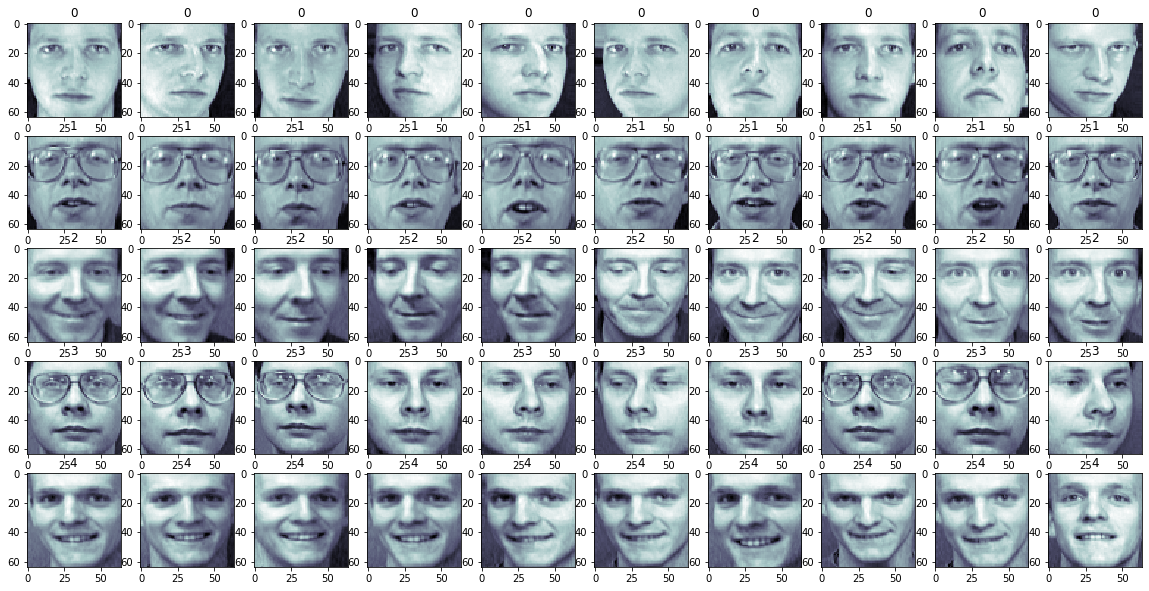

In [100]:
incrPCA(300)

Пока лица вполне различимы.

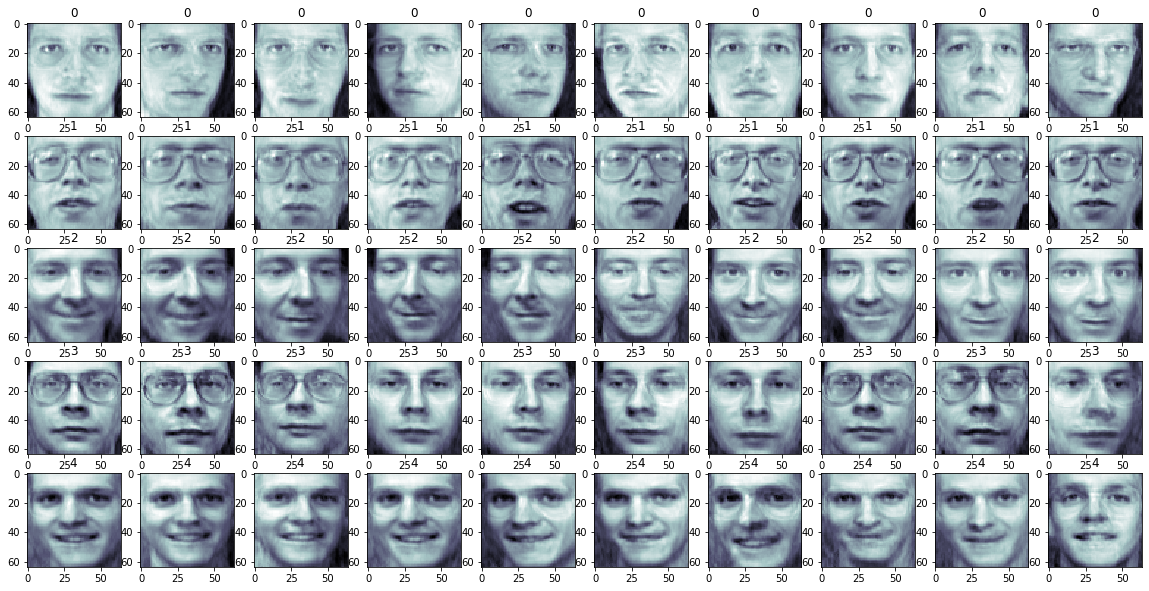

In [101]:
incrPCA(100)

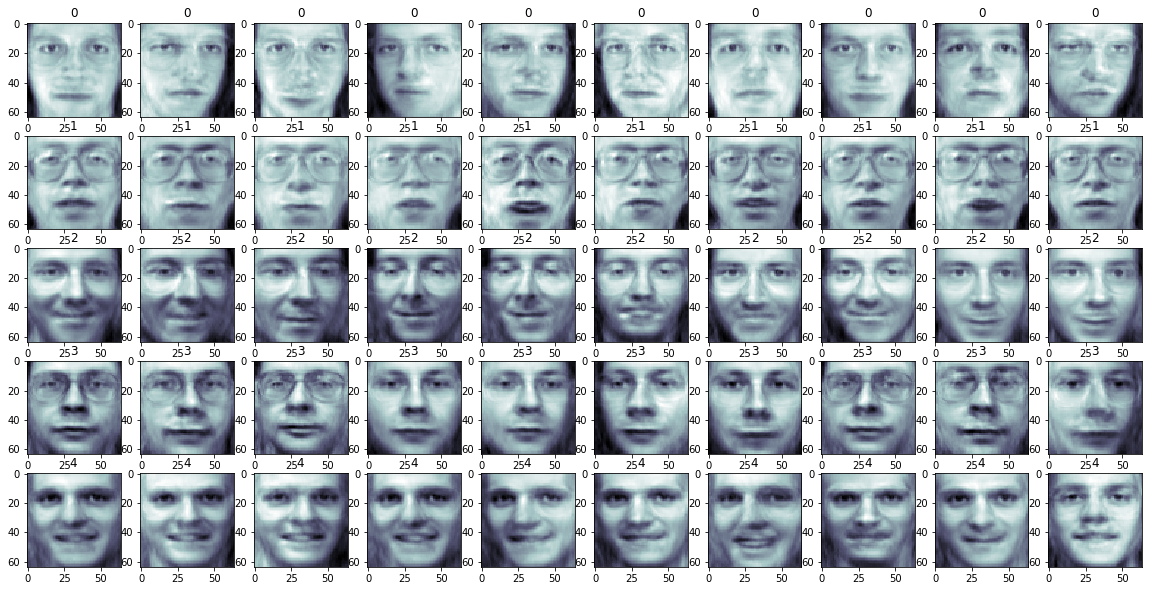

In [102]:
incrPCA(50)

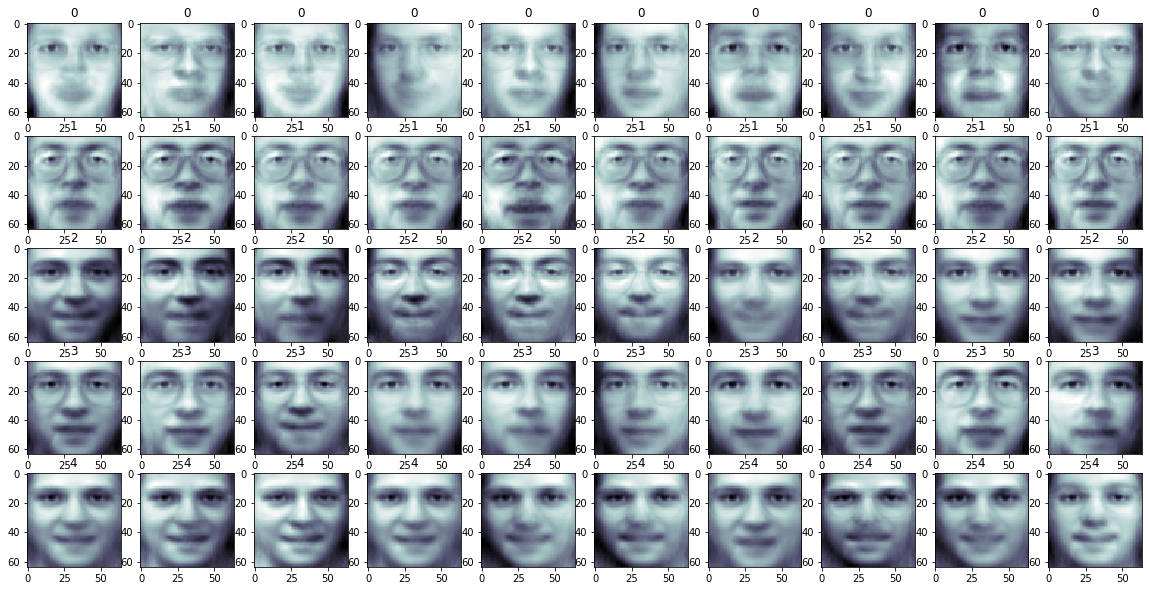

In [103]:
incrPCA(10)

Лица стали довольно похожи, но всё ещё выделяются брови, очки и рот.

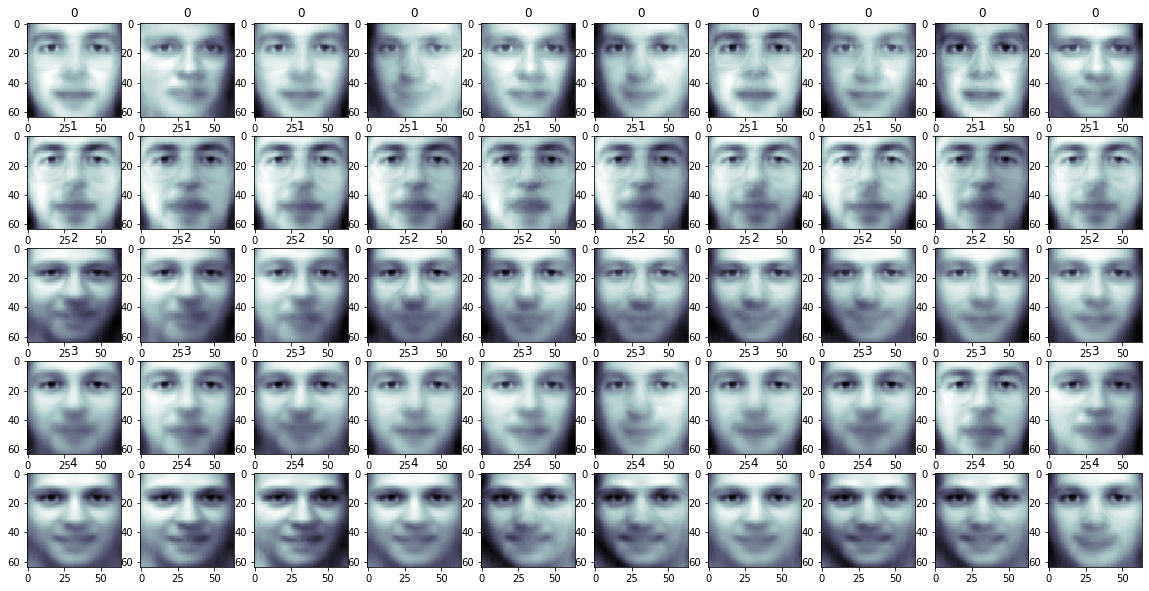

In [104]:
incrPCA(5)

Индивидуальные особенности почти исчезли, но глаза всё ещё немного отличаются.

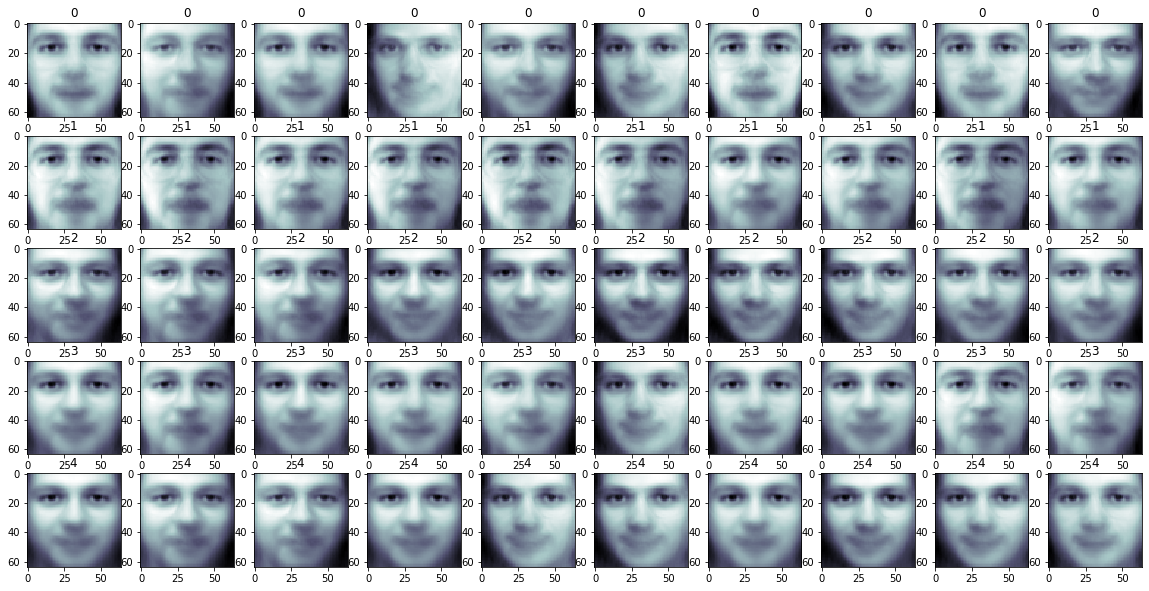

In [106]:
incrPCA(3)

Уже есть ощущение, что я вижу одного человека, но второй ряд всё ещё немного выделяется.

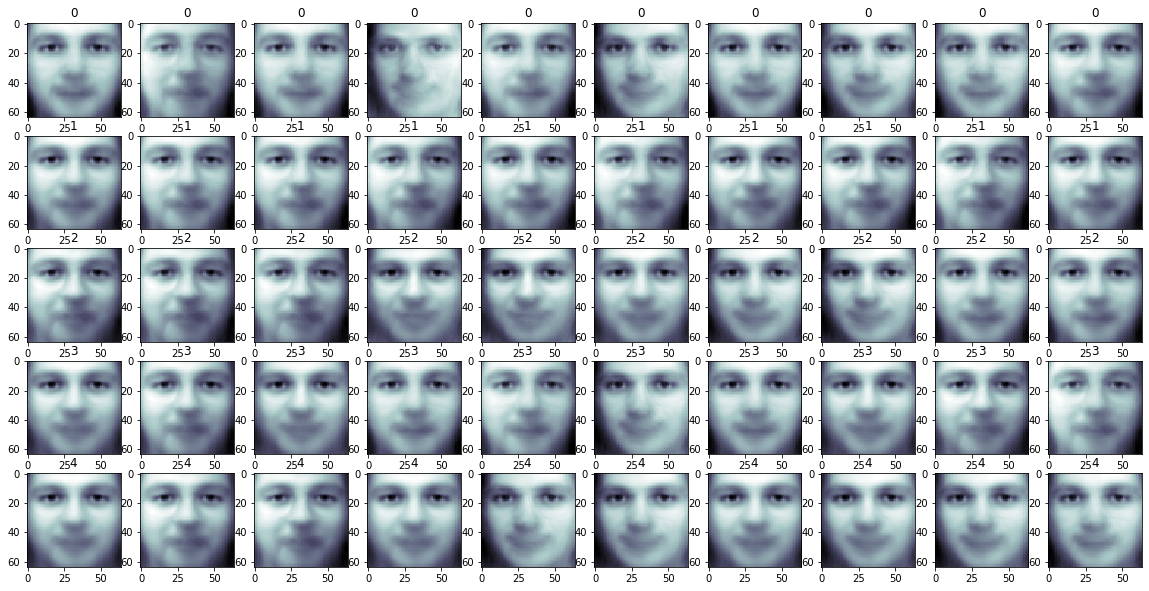

In [107]:
incrPCA(2)

Ну теперь уж точно индивидульные особенности пропали. То есть искомое k равно 2 или 3.

In [111]:
from pylab import cm

In [140]:
def plot_vis(alg, method):
    plt.figure(figsize=(10, 6))
    new_data = alg.fit_transform(X)
    cmap = cm.get_cmap('tab20', 5)
    sc = plt.scatter(new_data[:, 0], new_data[:, 1], c=y, cmap=cmap)
    plt.title("Visualisation with {}".format(method))
    plt.colorbar(sc)
    plt.show()

In [141]:
%config InlineBackend.figure_format = 'svg'

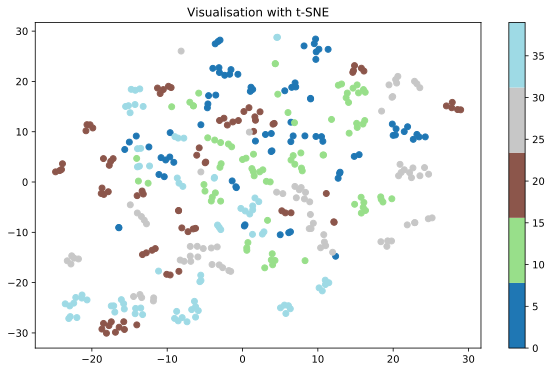

In [142]:
plot_vis(TSNE(n_components=2), "t-SNE")

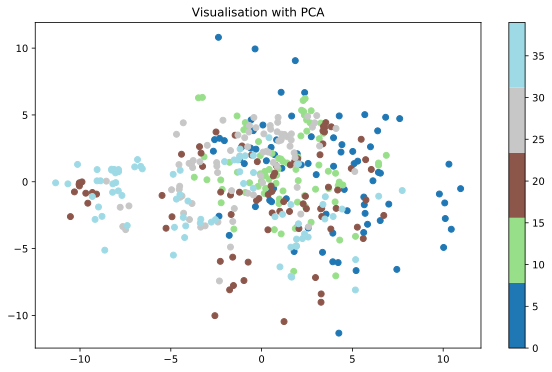

In [143]:
plot_vis(IncrementalPCA(n_components=2), "PCA")

Как видим, PCA не увидел различия в лицах и не смог разделить данные на кластеры, t-SNE же неплохо справился с этой задачей. Приходим к выводу, что для изображений всё-таки лучше использовать t-SNE (нелинейные зависимости).